# Chapter 11 - I2VIS - Clean version

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [12]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

100 km sticky air layer, 500x500 km box
We define the materials used in this computation here.
We introduce functions that compute the density on the markers.
We introduce a function that computes the initial conditions (on the markers).

In [13]:
struct Materials
    # 1 - mantle
    # 2 - plume
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
         # These are the values used in Gerya's problem 11.1
         new([3e-5,2e-5,0.0],[3300.,3200.,1.0],[2e-8,3e-8,0.0],[1000.,1000.,3.3e6],[3.0,2.0,300.0],[1e21,1e20,1e17])
    end    
end

function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    
    for i in 1:markers.nmark                
        # receompute density using the current temperature value
        # assume reference temperature is 273.0
        markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        # materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
    end
end

# function initialize_marker_properties!(markers::Markers,materials::Materials)
#     eta = markers.scalarFields["eta"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integerFields["material"]
#     for i in 1:markers.nmark                
#         markers.scalars[eta,i] = materials.eta[mmat[i]]
#     end
# end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        if my < 1e5
             # sticky air
             markers.integers[material,i] = 3
             markers.scalars[T,i] = 273.0
             markers.scalars[eta,i] = materials.eta[3]
             markers.scalars[alpha,i] = materials.alpha[3]  
             markers.scalars[cp,i] = materials.Cp[3]  
         elseif mr < 1e5
             # plume
             markers.integers[material,i] = 2
             markers.scalars[T,i] = 1800.0
             markers.scalars[eta,i] = materials.eta[2]
             markers.scalars[alpha,i] = materials.alpha[2]            
            markers.scalars[cp,i] = materials.Cp[2]  
         else
            # ambient mantle
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 1500.0            
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]            
            markers.scalars[cp,i] = materials.Cp[1]  
         end
    end
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat step 4.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 2nd order Runge-Kutta

TO DO:
1. Calculate rhox (rho at vx points) -> (optionally) pass to Stokes.jl (Max)
3. Add free-surface stabilization terms to Stokes.jl (Lucy)
4. Add functionality for shear heating (Max)
5. Add functionality for adiabatic heating (Uthkarsh)

Creating Markers...
  0.008273 seconds (19 allocations: 2.159 MiB, 94.50% gc time)
Initial condition...
  0.005301 seconds (90.71 k allocations: 1.443 MiB)
Trying with timestep 1.3157686946348284e12
dTmax=2.4912823505003416 dt=1.3157686946348284e12
-3.877612255961526e-9 2.2148760451597403e-9Finished Step 1 time=0.041770434750312016 Myr
  0.158057 seconds (103.15 k allocations: 44.161 MiB, 4.95% gc time)


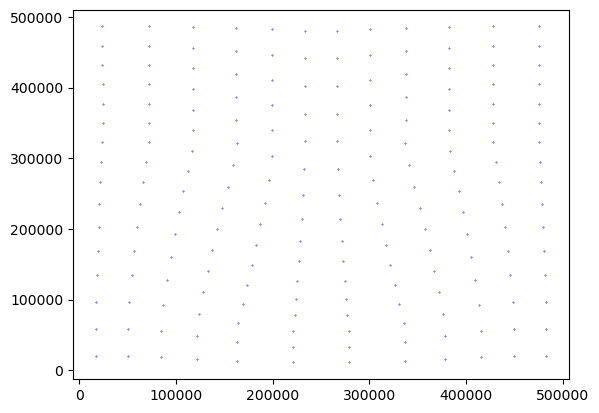

In [34]:
function run(nstep::Int64)
#     nstep=1

    nx = 40
    ny = 50
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    Tbcval = [0.0,0.0,273.0,1500.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 4
    marky = 4
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp_c = 1250. .* ones(grid.ny+1,grid.nx+1);
    H = zeros(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0

    local rho_c
    local rho
    local Cp_c
    local eta_s
    local eta_n
    local vxc
    local vyc
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast
#     Cp_c = nothing
#     rho = nothing
#     rho_c = nothing
#     eta_s = nothing
#     eta_n = nothing
#     vxc = nothing
#     vyc = nothing
#     shear_heating = nothing
#     vx = nothing
#     vy = nothing
#     rho_vx = nothing

    output_dir = "test"
    for itime in 1:nstep
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_basic_node(markers,grid,["eta",]);
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new = marker_to_cell_center(markers,grid,["rho","Cp","alpha","eta","T"])
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(rho,rho_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,T_last_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_vy_new)
        Cp_c = copy(Cp_c_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.5*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)

        # get temperature at cell centers
        Tlast = ghost_temperature_center(grid,Tlast,Tbcval);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        while dTmax >= 10.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
        # dT_remaining = dTemp
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end

        
        print(minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
end
@time run(1)


figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

In [32]:
Cp_c

6×5 Matrix{Float64}:
    3.3e6         3.3e6         3.3e6         3.3e6         3.3e6
    2.23961e6     2.23961e6     2.23961e6     2.23961e6     2.23961e6
    1.04094e5     1.04094e5     1.04094e5     1.04094e5     1.04094e5
 1000.0        1000.0        1000.0        1000.0        1000.0
 1000.0        1000.0        1000.0        1000.0        1000.0
 1000.0        1000.0        1000.0        1000.0        1000.0

In [33]:
using Profile
@profview run(10)

Creating Markers...
  0.000860 seconds (19 allocations: 2.159 MiB)
Initial condition...
  0.006911 seconds (90.71 k allocations: 1.443 MiB)
Trying with timestep 2.7117439085824255e11
dTmax=0.5253752806927423 dt=2.7117439085824255e11
-1.8814611513200135e-8 5.835556758433846e-9Finished Step 1 time=0.008608710820896589 Myr


LoadError: UndefVarError: rho not defined